In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
    
    return mean_results


## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

import numpy as np
import xarray as xr
from scipy.stats import t

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.DataArrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, standard error on regression,
    and R-squared between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    # 1. Ensure that the data are properly aligned to each other. 
    x, y = xr.align(x, y)
    
    # 2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        x = x.shift(time=-lagx).dropna(dim='time')
        x, y = xr.align(x, y)

    if lagy != 0:
        y = y.shift(time=-lagy).dropna(dim='time')
        x, y = xr.align(x, y)
 
    # 3. Compute data length, mean and standard deviation along time axis for further use
    n = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    # 4. Compute covariance along time axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / n
    
    # 5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    # 6. Compute regression slope and intercept
    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope
    y_pred = intercept + slope * x
    res = y - y_pred

    # 7. Compute P-value and standard error
    # Compute t-statistics
    tstats = cor * np.sqrt(n-2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats
    
    pval = t.sf(tstats, n-2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # 8. Compute R-squared
    sst = np.sum((y - ymean) ** 2, axis=0)
    ssr = np.sum(res ** 2, axis=0)
    r_squared = 1 - ssr / sst

    r_squared = xr.DataArray(r_squared, dims=cor.dims, coords=cor.coords)

    return slope, intercept, pval, stderr, r_squared, y_pred


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [4]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

# -- Create directories
checkDir(out_path)

### Open 1pctCO2-bgc data

NEP

In [5]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-bgc'
var_name = 'nep'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_nep.append(content)

# Subsetting latitude
ds_nep = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_nep]

# Retain from year 1850 to 1989
ds_nep = [a.isel(time = slice(0,1680)) for a in ds_nep]

# Resample from months to Y
ds_nep = [a.resample(time="Y", label='right').mean() for a in ds_nep]

# Uniform calendar
for i, item in enumerate(ds_nep):
    ds_nep[i] = ds_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_nep[i]['time'] = pd.date_range(start = "1850", periods=140, freq = "YS")

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_nep[i] = ds_nep[i].where(ds_nep[i] != -3.7270379e-07)


In [6]:
for i, item in enumerate(ds_nep):
    if item.esm in {"BCC-CSM2-MR","E3SM-1-1-ECA","TaiESM1","NorESM2-MM"}:
        del ds_nep[i]
    print(ds_nep[i].esm)

ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


NBP

In [22]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-bgc'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_nbp.append(content)

# Subsetting latitude
ds_nbp = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_nbp]

# Retain from year 1850 to 1989
ds_nbp = [a.isel(time = slice(0,1680)) for a in ds_nbp]

ds_nbp[1] = ds_nbp[1].assign_coords(time = ds_nbp[0].time)
ds_nbp[9] = ds_nbp[9].assign_coords(time = ds_nbp[0].time)

# Resample from months to Y
ds_nbp = [a.resample(time="Y", label='right').mean() for a in ds_nbp]

# Uniform calendar
for i, item in enumerate(ds_nbp):
    ds_nbp[i] = ds_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_nbp[i]['time'] = pd.date_range(start = "1850", periods=140, freq = "YS")

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_nbp[i] = ds_nbp[i].where(ds_nbp[i] != -3.7270379e-07)


In [23]:
for i, item in enumerate(ds_nbp):
    if item.esm in {"BCC-CSM2-MR","E3SM-1-1-ECA","TaiESM1","NorESM2-MM"}:
        del ds_nbp[i]
    print(ds_nbp[i].esm)

ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


### Open ssp585 data

NEP

In [24]:
var_name = "nep"
scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nep.append(content)    

# Subsetting latitude
ds_ssp_nep = [a.sel(lat=slice(-30,30)) for a in ds_ssp_nep]
# Select time periods
ds_ssp_nep = [a.sel(time = slice("2015-01", "2100-12")) for a in ds_ssp_nep]
# Resample from months to years
ds_ssp_nep = [a.resample(time="Y", label='right').mean() for a in ds_ssp_nep]

for i, item in enumerate(ds_ssp_nep):
    ds_ssp_nep[i] = ds_ssp_nep[i].assign_attrs(esm=files_list[i].source_id)
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nep[i]['time'] = item.indexes['time'].to_datetimeindex()


# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_ssp_nep[i] = ds_ssp_nep[i].where(ds_ssp_nep[i] != -6.18386321e-06)
    if files_list[i].source_id == "CESM2-WACCM":
        ds_ssp_nep[i] = ds_ssp_nep[i]*-1
        ds_ssp_nep[i] = ds_ssp_nep[i].assign_attrs(esm=files_list[i].source_id)
    if files_list[i].source_id == "UKESM1-0-LL":
        ds_ssp_nep[i]["time"] = ds_ssp_nep[0]["time"]

NBP

In [25]:
var_name = "nbp"
scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

ds_ssp_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nbp.append(content)    

# Subsetting latitude
ds_ssp_nbp = [a.sel(lat=slice(-30,30)) for a in ds_ssp_nbp]
# Select time periods
ds_ssp_nbp = [a.sel(time = slice("2015-01", "2100-12")) for a in ds_ssp_nbp]
# Resample from months to years
ds_ssp_nbp = [a.resample(time="Y", label='right').mean() for a in ds_ssp_nbp]

for i, item in enumerate(ds_ssp_nbp):
    ds_ssp_nbp[i] = ds_ssp_nbp[i].assign_attrs(esm=files_list[i].source_id)
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nbp[i]['time'] = item.indexes['time'].to_datetimeindex()


# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_ssp_nbp[i] = ds_ssp_nbp[i].where(ds_ssp_nbp[i] != -6.18386321e-06)        

In [26]:
ds_ssp_nep = xr_mean_list(ds_ssp_nep)
ds_ssp_nbp = xr_mean_list(ds_ssp_nbp)

In [27]:
del ds_ssp_nep["BCC-CSM2-MR"], ds_ssp_nep["E3SM-1-1-ECA"], ds_ssp_nep["TaiESM1"], ds_ssp_nep["NorESM2-MM"]
del ds_ssp_nbp["E3SM-1-1-ECA"], ds_ssp_nbp["TaiESM1"], ds_ssp_nbp["NorESM2-MM"]

In [28]:
models = list(ds_ssp_nbp.keys())
print(models)

['ACCESS-ESM1-5', 'CESM2-WACCM', 'CMCC-ESM2', 'CNRM-ESM2-1', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL']


### Open CO2

In [29]:

data = np.loadtxt('F:/Data/analysis/1pctCO2-bgc/co2_1pctCO2-bgc.txt')

# Extract lon, lat, and data values from the loaded data
time = data[:140, 0]
values = data[:140, 1]

ds_co2 = []
for i,item in enumerate(ds_nep):

    lons = item.lon.values
    lats = item.lat.values

    # Create coordinate arrays
    time_coords = pd.date_range(start = "1850", periods=time.shape[0], freq = "YS") # xr.DataArray(time, dims='time', name='time')
    lon_coords = xr.DataArray(lons, dims='lon', name='lon')
    lat_coords = xr.DataArray(lats, dims='lat', name='lat')

    # Create a sample data array with a constant value for all grid cells
    constant_value = 10  # Replace with your desired constant value
    data_values = np.full((len(time), len(lats), len(lons)), constant_value)

    # Create the DataArray
    co2 = xr.DataArray(data_values, 
                            coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
                            dims=['time', 'lat', 'lon'], 
                            name='ppm').astype("float64")

    for i,item in enumerate(time):
        co2[i] = values[i]
    ds_co2.append(co2)

ds_co2 = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_co2]

Multimodel Mean

In [30]:
# ds_nep_mean = xr.concat(ds_nep, dim = "esm", coords = "minimal", compat = "override").mean(dim = "esm")

# threshold = 1e-5
# ds_nep_mean = ds_nep_mean.where(abs(ds_nep_mean) >= threshold, 0)


Amazon Mean

In [31]:
# ds_nep_mean_amz = zonal_stat(ds_nep_mean, geodf).sel(region = 1)
ds_co2_amz = zonal_stat(ds_co2[0], geodf).sel(region = 1)

df_amz = ds_co2_amz.to_dataframe().drop(columns = ["region"])
for m, mm in enumerate(models):
    
    content = zonal_stat(ds_nep[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nep":"nep " + mm})
    content1 = zonal_stat(ds_nbp[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + mm})
    df_amz = pd.concat([df_amz, content, content1], axis = 1)

# 10 years running mean
# for m, mm in enumerate(models):
#         df_amz["nep " + mm] = df_amz["nep " + mm].rolling(10, center=True).mean()
#         df_amz["nbp " + mm] = df_amz["nbp " + mm].rolling(10, center=True).mean()
# df_amz = df_amz.dropna()

In [32]:
# ds_nep_mean_amz = zonal_stat(ds_nep_mean, geodf).sel(region = 1)
ds_co2_amz = zonal_stat(ds_co2[0], geodf).sel(region = 1)

df_amz_ssp = pd.DataFrame()
for k in ds_ssp_nep.keys():
    # rr = files_list[k].parent_variant_label
    content = zonal_stat(ds_ssp_nep[k], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nep":"nep " + k}) # + " " + rr
    content1 = zonal_stat(ds_ssp_nbp[k], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + k}) # + " " + rr

    df_amz_ssp = pd.concat([df_amz_ssp, content, content1], axis = 1)

# 10 years running mean
# for k in ds_ssp_nep.keys():
#         # rr = files_list[k].parent_variant_label
#         # df_amz_ssp["nep " + k] = df_amz_ssp["nep " + k].rolling(10, center=True).mean()
#         # df_amz_ssp["nbp " + k] = df_amz_ssp["nbp " + k].rolling(10, center=True).mean()
# df_amz_ssp = df_amz_ssp.dropna()

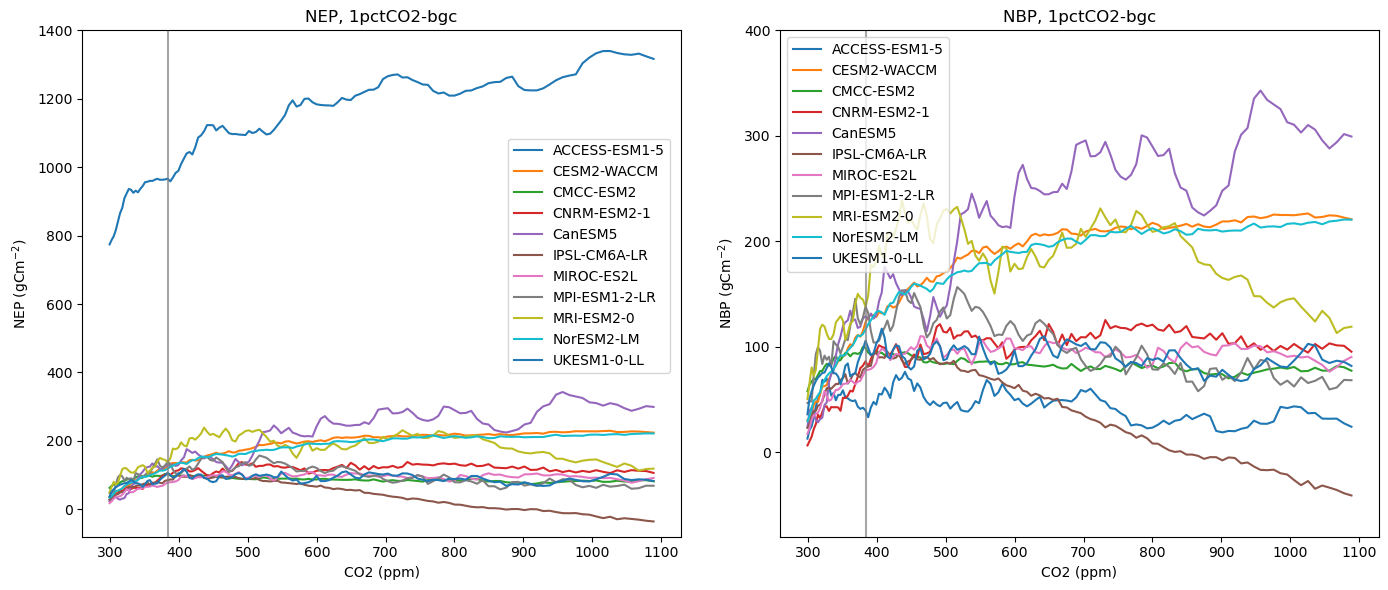

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig = plt.figure(figsize=(14, 6))

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
for m, mm in enumerate(models):
    ax0.plot(df_amz["ppm"], df_amz['nep ' + mm].rolling(10, center=True).mean(), label=mm)  # Line plot for NEP
# Set labels and title
ax0.set_xlabel("CO2 (ppm)")
ax0.set_ylabel("NEP (gCm$^{-2}$)")
ax0.set_ylim(-80, 1400)

# Highlight a specific CO2 value with a vertical line
ax0.axvline(df_amz.iloc[30]["ppm"], color="grey", alpha=0.7)

# Add legend and title
ax0.legend(models, loc='upper left', bbox_to_anchor = [0.7, 0.8])
ax0.set_title("NEP, 1pctCO2-bgc")

# Second plot for NBP
ax1 = fig.add_subplot(122)
for m, mm in enumerate(models):
    ax1.plot(df_amz["ppm"], df_amz['nbp ' + mm].rolling(10, center=True).mean())  # Line plot for NBP
    
# Set labels and title
ax1.set_xlabel("CO2 (ppm)")
ax1.set_ylabel("NBP (gCm$^{-2}$)")
ax1.set_ylim(-80, 400)

# Highlight a specific CO2 value with a vertical line
ax1.axvline(df_amz.iloc[30]["ppm"], color="grey", alpha=0.7)

# Add legend and title
ax1.legend(models, loc = "upper left")
ax1.set_title("NBP, 1pctCO2-bgc")

plt.tight_layout()
plt.show()


### Linear Regression of NEP and CO2

The relationship between NEP and CO2 is logarithimic, but if we consider the range of CO2 ppm of historical (280-400) and ssp585 (400-1135) separately, it is linear.\
For ssp585, the period is from 1886-01-01 to 1989-01-01 (104 yrs)

In [34]:
results_hist_nep = []
results_hist_nbp = []
results_ssp_nep = []
results_ssp_nbp = []

for m, mm in enumerate(models):

    slope,intercept,pval,stderr,r2,ypred = lag_linregress_3D(ds_co2[m][:35],ds_nep[m][:35])
    results_hist_nep.append({
            'slope': slope,
            'intercept': intercept,
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    slope,intercept,pval,stderr,r2,ypred = lag_linregress_3D(ds_co2[m][:35],ds_nbp[m][:35])
    results_hist_nbp.append({
            'slope': slope,
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    slope,intercept,pval,stderr,r2,ypred = lag_linregress_3D(ds_co2[m][36:],ds_nep[m][36:])
    results_ssp_nep.append({
            'slope': slope,
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    slope,intercept,pval,stderr,r2,ypred = lag_linregress_3D(ds_co2[m][36:],ds_nbp[m][36:])
    results_ssp_nbp.append({
            'slope': slope,
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

In [35]:
# Save and export regression list data
import pickle
data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"reg_1pctCO2-bgc_hist_nep"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_nep, fp)

with open(os.path.join(data_path+"reg_1pctCO2-bgc_hist_nbp"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_nbp, fp)

with open(os.path.join(data_path+"reg_1pctCO2-bgc_ssp_nep"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_nep, fp)

with open(os.path.join(data_path+"reg_1pctCO2-bgc_ssp_nbp"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_nbp, fp)


In [36]:
coef_hist_nep = xr.concat([zonal_stat(a["slope"],geodf).sel(region = 1) for a in results_hist_nep], dim = "models").to_dataframe(name = "coef_hist_nep").drop(columns = "region")
coef_hist_nep = coef_hist_nep.rename(index=dict(zip(coef_hist_nep.index, models)))

coef_hist_nbp = xr.concat([zonal_stat(a["slope"],geodf).sel(region = 1) for a in results_hist_nbp], dim = "models").to_dataframe(name = "coef_hist_nbp").drop(columns = "region")
coef_hist_nbp = coef_hist_nbp.rename(index=dict(zip(coef_hist_nbp.index, models)))

coef_ssp_nep = xr.concat([zonal_stat(a["slope"],geodf).sel(region = 1) for a in results_ssp_nep], dim = "models").to_dataframe(name = "coef_nep_ssp585").drop(columns = "region")
coef_ssp_nep = coef_ssp_nep.rename(index=dict(zip(coef_ssp_nep.index, models)))

coef_ssp_nbp = xr.concat([zonal_stat(a["slope"],geodf).sel(region = 1) for a in results_ssp_nbp], dim = "models").to_dataframe(name = "coef_nbp_ssp585").drop(columns = "region")
coef_ssp_nbp = coef_ssp_nbp.rename(index=dict(zip(coef_ssp_nbp.index, models)))

coef = pd.concat([coef_hist_nep, coef_hist_nbp, coef_ssp_nep, coef_ssp_nbp], axis = 1)

In [37]:
interc_ssp_nep = xr.concat([zonal_stat(a["intercept"],geodf).sel(region = 1) for a in results_ssp_nep], dim = "models").to_dataframe(name = "interc_nep_ssp585").drop(columns = "region")
interc_ssp_nep = interc_ssp_nep.rename(index=dict(zip(interc_ssp_nep.index, models)))

interc_ssp_nbp = xr.concat([zonal_stat(a["intercept"],geodf).sel(region = 1) for a in results_ssp_nbp], dim = "models").to_dataframe(name = "interc_nbp_ssp585").drop(columns = "region")
interc_ssp_nbp = interc_ssp_nbp.rename(index=dict(zip(interc_ssp_nbp.index, models)))

df_amz_interc = pd.concat([interc_ssp_nep, interc_ssp_nbp], axis = 1)

In [38]:
df_amz_pred = pd.DataFrame()
for m, mm in enumerate(models):
    
    content = zonal_stat(results_ssp_nep[m]["y_pred"],geodf).sel(region = 1).to_dataframe(name = "nep_pred " + mm).drop(columns = ["region"])
    content1 = zonal_stat(results_ssp_nbp[m]["y_pred"],geodf).sel(region = 1).to_dataframe(name = "nbp_pred " + mm).drop(columns = ["region"])
    df_amz_pred = pd.concat([df_amz_pred, content, content1], axis = 1)
    df_amz = pd.concat([df_amz, content, content1], axis = 1)

Plot regressions coefficients

<AxesSubplot: xlabel='models'>

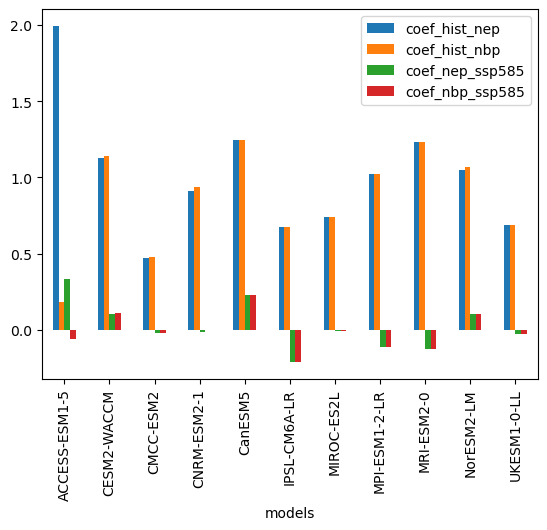

In [39]:
coef.plot.bar(stacked = False)

Plot predicted NEP vs original NEP

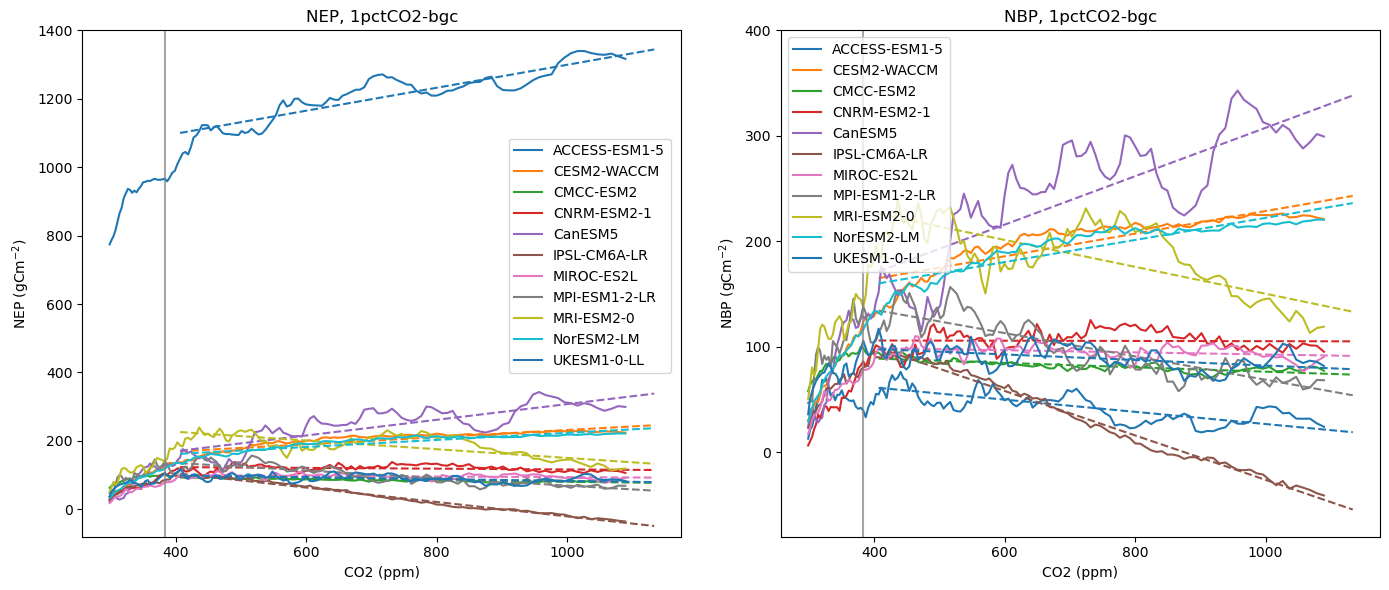

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig = plt.figure(figsize=(14, 6))

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
for m, mm in enumerate(models):
    # Plot the first line
    line1, = ax0.plot(df_amz["ppm"], df_amz[f'nep {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax0.plot(df_amz["ppm"], df_amz[f'nep_pred {mm}'], linestyle='--', color=line1.get_color(), label='_nolegend_')# Set labels and title

ax0.set_xlabel("CO2 (ppm)")
ax0.set_ylabel("NEP (gCm$^{-2}$)")
ax0.set_ylim(-80, 1400)

# Highlight a specific CO2 value with a vertical line
ax0.axvline(df_amz.iloc[30]["ppm"], color="grey", alpha=0.7)

# Add legend and title
ax0.legend(models, loc='upper left', bbox_to_anchor = [0.7, 0.8])
ax0.set_title("NEP, 1pctCO2-bgc")

# Second plot for NBP
ax1 = fig.add_subplot(122)
for m, mm in enumerate(models):
    # Plot the first line
    line1, = ax1.plot(df_amz["ppm"], df_amz[f'nbp {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax1.plot(df_amz["ppm"], df_amz[f'nbp_pred {mm}'], linestyle='--', color=line1.get_color(), label='_nolegend_')# Set labels and title
        
# Set labels and title
ax1.set_xlabel("CO2 (ppm)")
ax1.set_ylabel("NBP (gCm$^{-2}$)")
ax1.set_ylim(-80, 400)

# Highlight a specific CO2 value with a vertical line
ax1.axvline(df_amz.iloc[30]["ppm"], color="grey", alpha=0.7)

# Add legend and title
ax1.legend(models, loc = "upper left")
ax1.set_title("NBP, 1pctCO2-bgc")

plt.tight_layout()
plt.show()


### Remove the eCO2 effect estimated from 1pctCo2-bgc simulations from NEP and NBP in ssp585

In [41]:
# Interpolate co2 to have 86 years as ssp585

x_old = np.linspace(1, ds_co2_amz.to_dataframe().drop(columns = ["region"]).shape[0], ds_co2_amz.to_dataframe().drop(columns = ["region"]).shape[0])
x_new = np.linspace(1, len(df_amz_ssp.index), len(df_amz_ssp.index))

# Create an empty DataFrame to store interpolated values
df_amz_ssp_eCO2 = pd.DataFrame(index=df_amz_ssp[:86].index)

# Interpolate the values of CO2 and predict the NEP_eCO2 
for column in df_amz_ssp.columns:
    X = np.interp(x_new, x_old, ds_co2_amz.to_dataframe().drop(columns = ["region"]).ppm.values)
    if "nep" in column:
        a = coef_ssp_nep[coef_ssp_nep.index.to_series().apply(lambda idx: idx in column)].iloc[0].values
    if "nbp" in column: 
        a = coef_ssp_nbp[coef_ssp_nbp.index.to_series().apply(lambda idx: idx in column)].iloc[0].values
    df_amz_ssp_eCO2[column] = a * X
    
df_amz_ssp_eCO2.head(10)

,nep ACCESS-ESM1-5,nbp ACCESS-ESM1-5,nep CESM2-WACCM,nbp CESM2-WACCM,nep CMCC-ESM2,nbp CMCC-ESM2,nep CNRM-ESM2-1,nbp CNRM-ESM2-1,nep CanESM5,nbp CanESM5,...,nep MIROC-ES2L,nbp MIROC-ES2L,nep MPI-ESM1-2-LR,nbp MPI-ESM1-2-LR,nep MRI-ESM2-0,nbp MRI-ESM2-0,nep NorESM2-LM,nbp NorESM2-LM,nep UKESM1-0-LL,nbp UKESM1-0-LL
time,,,,,,,,,,,,,,,,,,,,,
2015-12-31 00:00:00,95.426688,-16.444708,29.796413,30.486959,-6.061882,-5.919501,-3.244454,-0.310313,65.226171,65.224407,...,-2.666362,-2.849700,-31.405006,-31.409082,-36.256765,-36.256765,29.383997,29.769517,-7.494745,-7.457449
2016-12-31 00:00:00,96.379881,-16.608970,30.094042,30.791486,-6.122433,-5.978629,-3.276862,-0.313413,65.877698,65.875917,...,-2.692996,-2.878165,-31.718702,-31.722819,-36.618925,-36.618925,29.677506,30.066877,-7.569608,-7.531940
2017-12-31 00:00:00,97.343143,-16.774968,30.394814,31.099229,-6.183623,-6.038382,-3.309612,-0.316546,66.536108,66.534309,...,-2.719911,-2.906930,-32.035712,-32.039870,-36.984910,-36.984910,29.974116,30.367378,-7.645262,-7.607217
2018-12-31 00:00:00,98.316473,-16.942700,30.698731,31.410189,-6.245453,-6.098760,-3.342705,-0.319711,67.201401,67.199583,...,-2.747107,-2.935996,-32.356036,-32.360236,-37.354721,-37.354721,30.273826,30.671020,-7.721707,-7.683281
2019-12-31 00:00:00,99.299873,-17.112167,31.005792,31.724366,-6.307922,-6.159762,-3.376140,-0.322909,67.873575,67.871740,...,-2.774585,-2.965363,-32.679674,-32.683916,-37.728357,-37.728357,30.576637,30.977804,-7.798942,-7.760132
2020-12-31 00:00:00,100.293342,-17.283370,31.315996,32.041760,-6.371031,-6.221389,-3.409917,-0.326139,68.552632,68.550778,...,-2.802344,-2.995031,-33.006626,-33.010909,-38.105819,-38.105819,30.882548,31.287729,-7.876968,-7.837771
2021-12-31 00:00:00,101.296879,-17.456308,31.629345,32.362371,-6.434780,-6.283640,-3.444037,-0.329402,69.238571,69.236699,...,-2.830384,-3.024999,-33.336891,-33.341217,-38.487107,-38.487107,31.191560,31.600794,-7.955786,-7.916195
2022-12-31 00:00:00,102.310486,-17.630981,31.945838,32.686198,-6.499168,-6.346516,-3.478499,-0.332699,69.931393,69.929502,...,-2.858705,-3.055268,-33.670469,-33.674839,-38.872221,-38.872221,31.503671,31.917001,-8.035393,-7.995407
2023-12-31 00:00:00,103.330805,-17.806811,32.264426,33.012170,-6.563983,-6.409808,-3.513189,-0.336016,70.628803,70.626893,...,-2.887215,-3.085738,-34.006257,-34.010671,-39.259884,-39.259884,31.817850,32.235302,-8.115529,-8.075144


In [42]:
df_amz_ssp_net = pd.DataFrame()
for column in df_amz_ssp.columns:
    df_amz_ssp_net[column] = df_amz_ssp[column].values - df_amz_ssp_eCO2[column].values
    
df_amz_ssp_net.index = df_amz_ssp.index

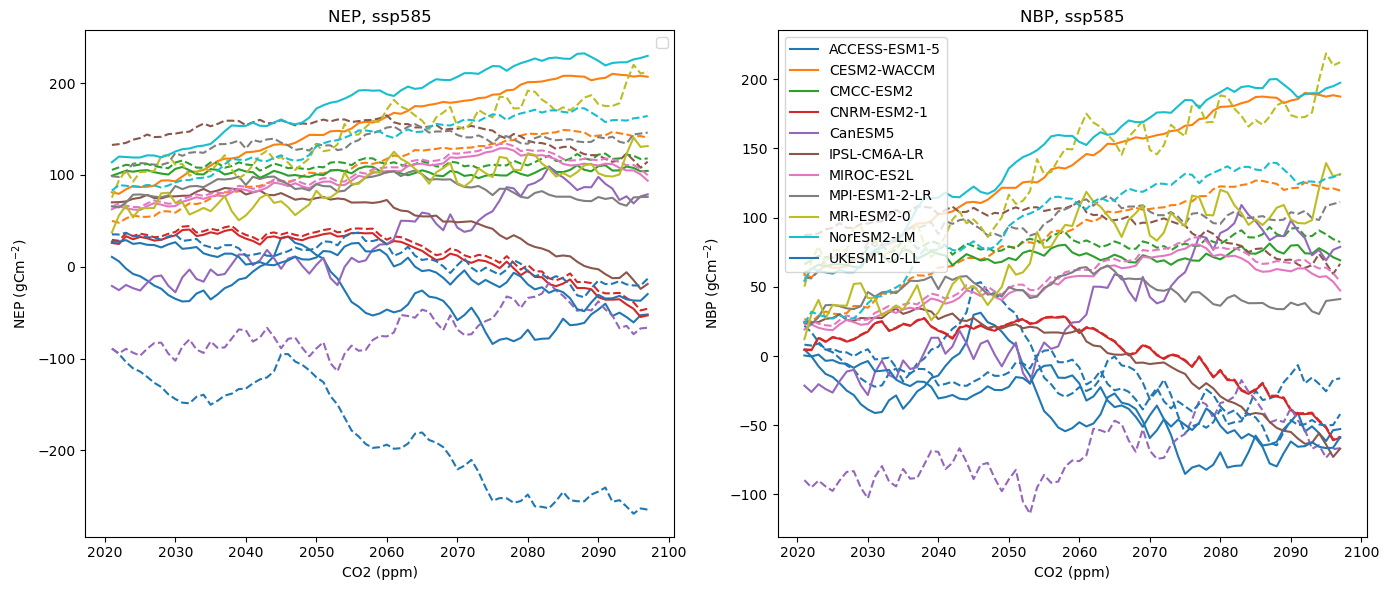

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig = plt.figure(figsize=(14, 6))

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
for m, mm in enumerate(models):
    # Plot the first line
    line1, = ax0.plot(df_amz_ssp.index, df_amz_ssp[f'nep {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax0.plot(df_amz_ssp_net.index, df_amz_ssp_net[f'nep {mm}'].rolling(10, center=True).mean(), linestyle='--', color=line1.get_color())# Set labels and title

ax0.set_xlabel("CO2 (ppm)")
ax0.set_ylabel("NEP (gCm$^{-2}$)")
# ax0.set_ylim(-200, 400)

# Highlight a specific CO2 value with a vertical line
# ax0.axvline(df_amz_ssp.iloc[30].index, color="grey", alpha=0.7)

# Add legend and title
ax0.legend("") #
ax0.set_title("NEP, ssp585")

# Second plot for NBP
ax1 = fig.add_subplot(122)
for m, mm in enumerate(models):
    # Plot the first line
    line2, = ax1.plot(df_amz_ssp.index, df_amz_ssp[f'nbp {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax1.plot(df_amz_ssp_net.index, df_amz_ssp_net[f'nbp {mm}'].rolling(10, center=True).mean(), linestyle='--', color=line2.get_color(), label = "_nolegend_")# Set labels and title
        
# Set labels and title
ax1.set_xlabel("CO2 (ppm)")
ax1.set_ylabel("NBP (gCm$^{-2}$)")
# ax1.set_ylim(-200, 400)

# Highlight a specific CO2 value with a vertical line
# ax1.axvline(df_amz_ssp.iloc[30].index, color="grey", alpha=0.7)

# Add legend and title
ax1.legend(models, loc = "upper left")
ax1.set_title("NBP, ssp585")

plt.tight_layout()
plt.show()
